In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.modelling import VAE

2023-12-13 09:29:31,370 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [2]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-13 09:29:31,721 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-13 09:29:45,915 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


In [3]:
# Validation Set
#df_list_val = df_list[:2]
#df_list_train = df_list[len(df_list_val):]

In [4]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

#preprocessor_val = Preprocesser(df_list=df_list_val, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
#tensor_val: np.array = preprocessor_val.preprocess_data()

print(tensor.shape)
#print(tensor_val.shape)

2023-12-13 09:29:45,955 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-13 09:29:46,200 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-13 09:29:46,203 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.25s) ...


(10, 10990, 7)


In [5]:
vae = VAE(tensor=tensor, latent_dims=2)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

2023-12-13 09:29:46,363 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2023-12-13 09:29:46,997 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

2023-12-13 09:29:47,045 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\engine\base_layer_utils.py:189: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [6]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               70148     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 10990, 7)          363074    
                                                                 
Total params: 433228 (1.65 MB)
Trainable params: 433222 (1.65 MB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [7]:
# TODO: Add callbacks, for EarlyStopping and LR Reduce
history = vae.fit(tensor, epochs=64, batch_size=2)#, validation_data=(tensor_val, tensor_val))

Epoch 1/64
5/5 [==============================] - 50s 9s/step - loss: 5970.4697 - reconstruction_loss: 5721.4336 - kl_loss: 0.2006
Epoch 2/64
5/5 [==============================] - 47s 9s/step - loss: 5556.3897 - reconstruction_loss: 5452.5259 - kl_loss: 3.0559
Epoch 3/64
5/5 [==============================] - 48s 10s/step - loss: 5255.5422 - reconstruction_loss: 5030.4741 - kl_loss: 20.2258
Epoch 4/64
5/5 [==============================] - 49s 10s/step - loss: 4671.0912 - reconstruction_loss: 4662.8369 - kl_loss: 34.5967
Epoch 5/64
5/5 [==============================] - 50s 10s/step - loss: 4754.8403 - reconstruction_loss: 4449.1431 - kl_loss: 37.3672
Epoch 6/64
5/5 [==============================] - 48s 10s/step - loss: 3996.4841 - reconstruction_loss: 3840.6497 - kl_loss: 28.2671
Epoch 7/64
5/5 [==============================] - 48s 10s/step - loss: 3587.2563 - reconstruction_loss: 3478.5520 - kl_loss: 25.6119
Epoch 8/64
5/5 [==============================] - 48s 10s/step - loss: 30

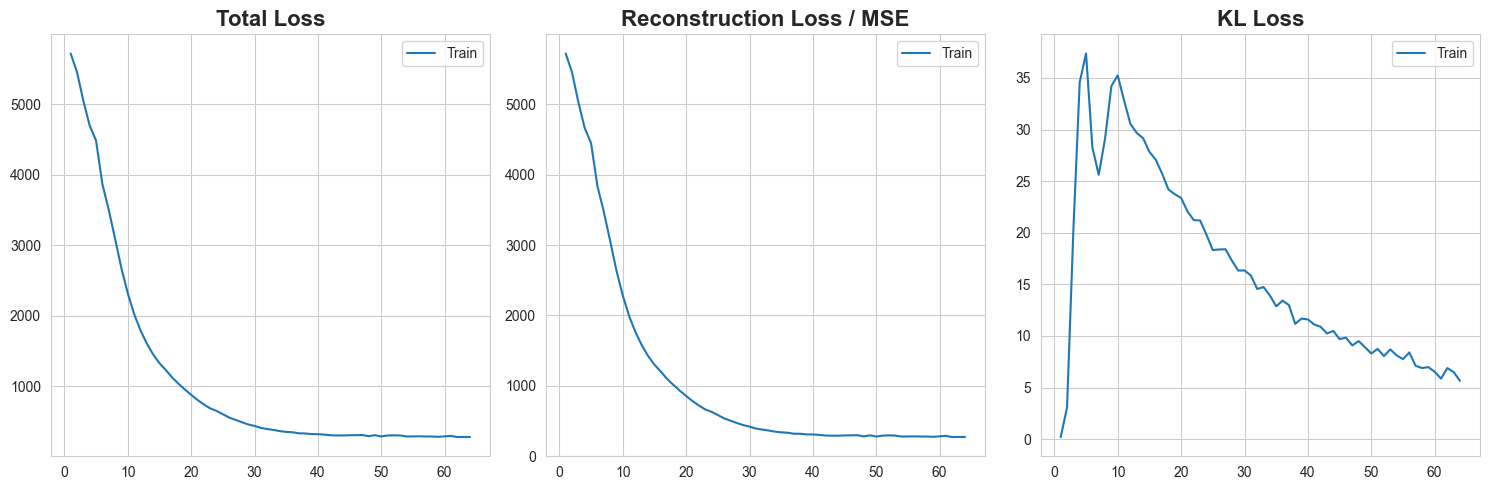

In [8]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    #loss_val = loss_dict["val_total_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    #rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    #kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    #sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss / MSE", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    #sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    #sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

plot_history(history)

## Save Model

In [11]:
vae.save("../models/e64_b2_43k_params")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

ValueError: Model <src.modelling.VAE object at 0x000001782B61B0A0> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

# Reconstruction Plotting

In [12]:
#val_sample = np.expand_dims(tensor_val[0], axis=0)
train_sample = np.expand_dims(tensor[0], axis=0)
#print(val_sample.shape)
print(train_sample.shape)

(1, 10990, 7)


In [13]:
#val_sample_reconstructed = vae.predict(val_sample)
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 2s 2s/step


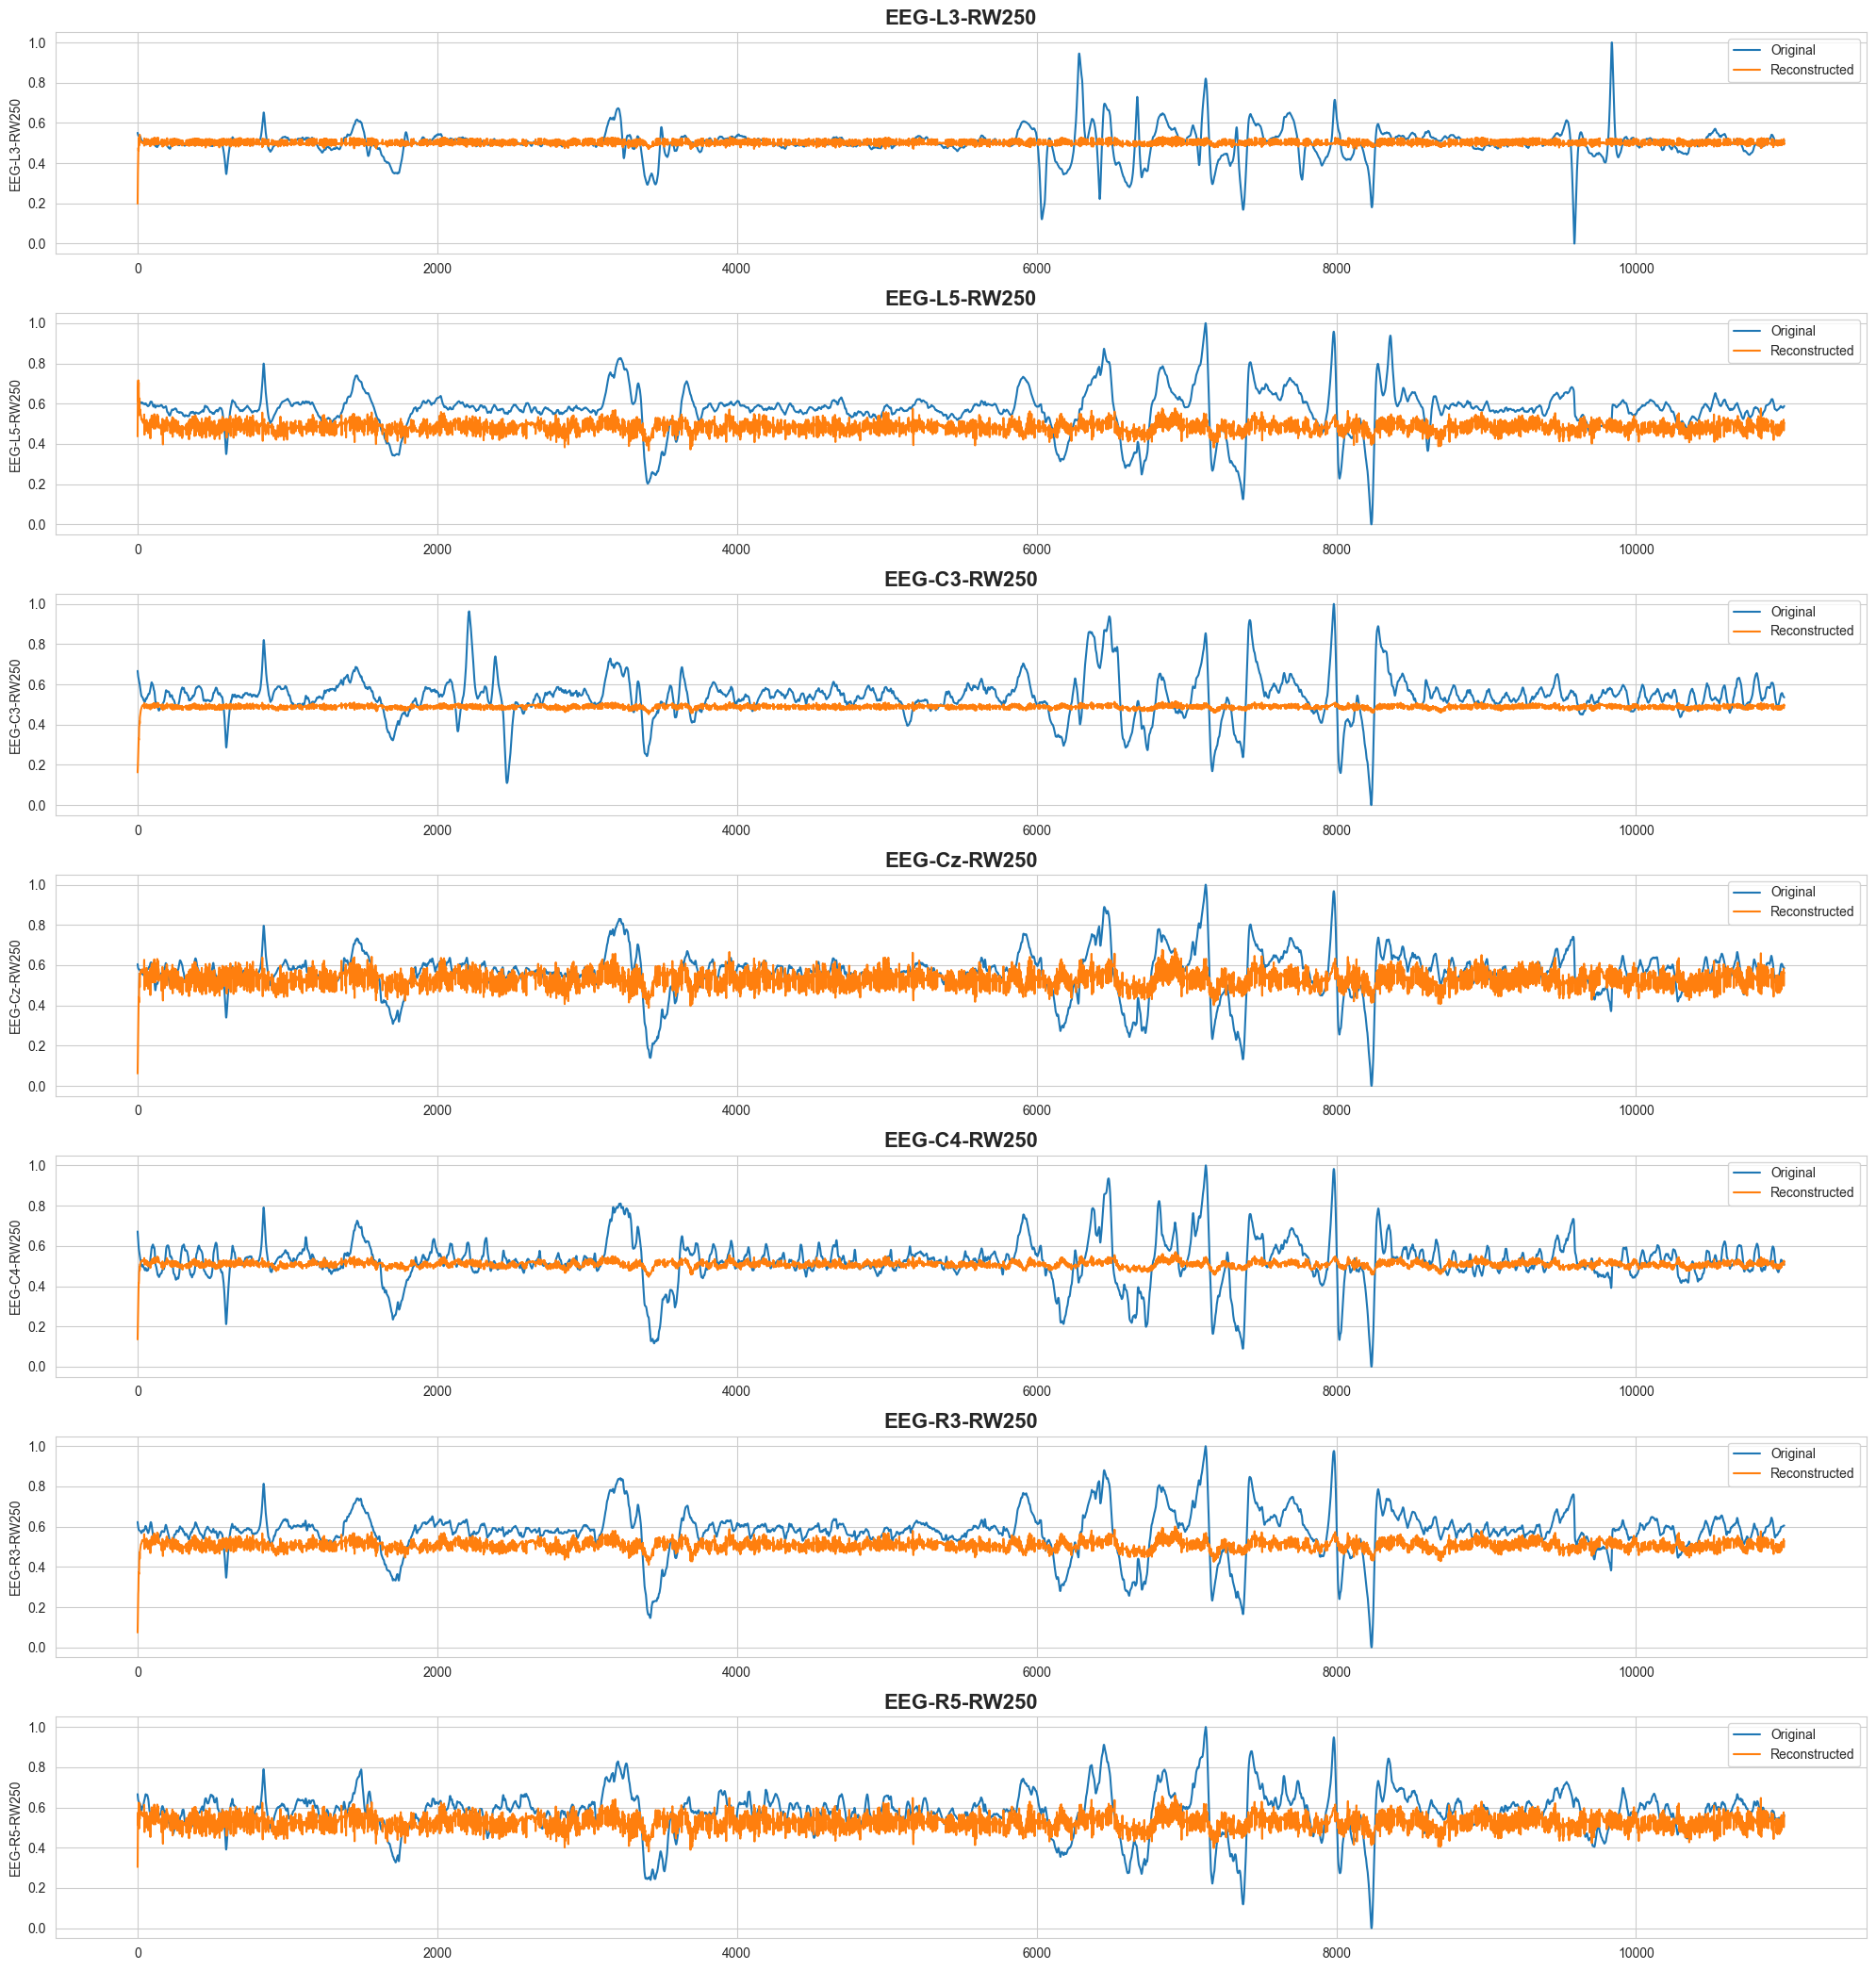

In [22]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [15]:
z_mean, z_log_var, z = vae.encoder.predict(tensor)

1/1 [==============================] - 1s 1s/step


In [16]:
z.shape

(10, 2)

In [18]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

# Generate synthetic time series data
num_samples = 1
synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, 2)
print(synthetic_time_series.shape)

1/1 [==============================] - 1s 547ms/step
Latent Samples: [[ 3.16038496 -0.24996714]]
(1, 10990, 7)


In [19]:
test = synthetic_time_series[0]
test.shape

(10990, 7)

In [20]:
test_df = pd.DataFrame(test, columns=FEATURE_NAMES)#, index=df_scaled_list[0].index)
test_df

,EEG-L3-RW250,EEG-L5-RW250,EEG-C3-RW250,EEG-Cz-RW250,EEG-C4-RW250,EEG-R3-RW250,EEG-R5-RW250
0,0.195995,0.453843,0.161318,0.060802,0.137606,0.075603,0.314932
1,0.289028,0.618432,0.177571,0.108741,0.174600,0.126468,0.445109
2,0.356810,0.681303,0.199130,0.172477,0.220728,0.176002,0.508675
3,0.403915,0.708627,0.225236,0.236331,0.269124,0.223539,0.548839
4,0.436544,0.734721,0.253785,0.298415,0.315609,0.270634,0.589739
...,...,...,...,...,...,...,...
10985,0.491959,0.520312,0.499201,0.582844,0.524530,0.537125,0.574954
10986,0.519248,0.465759,0.481082,0.495594,0.503222,0.495646,0.500266
10987,0.492974,0.494859,0.497704,0.556888,0.523073,0.523218,0.543854
10988,0.497350,0.499540,0.495710,0.558469,0.519489,0.525026,0.549016


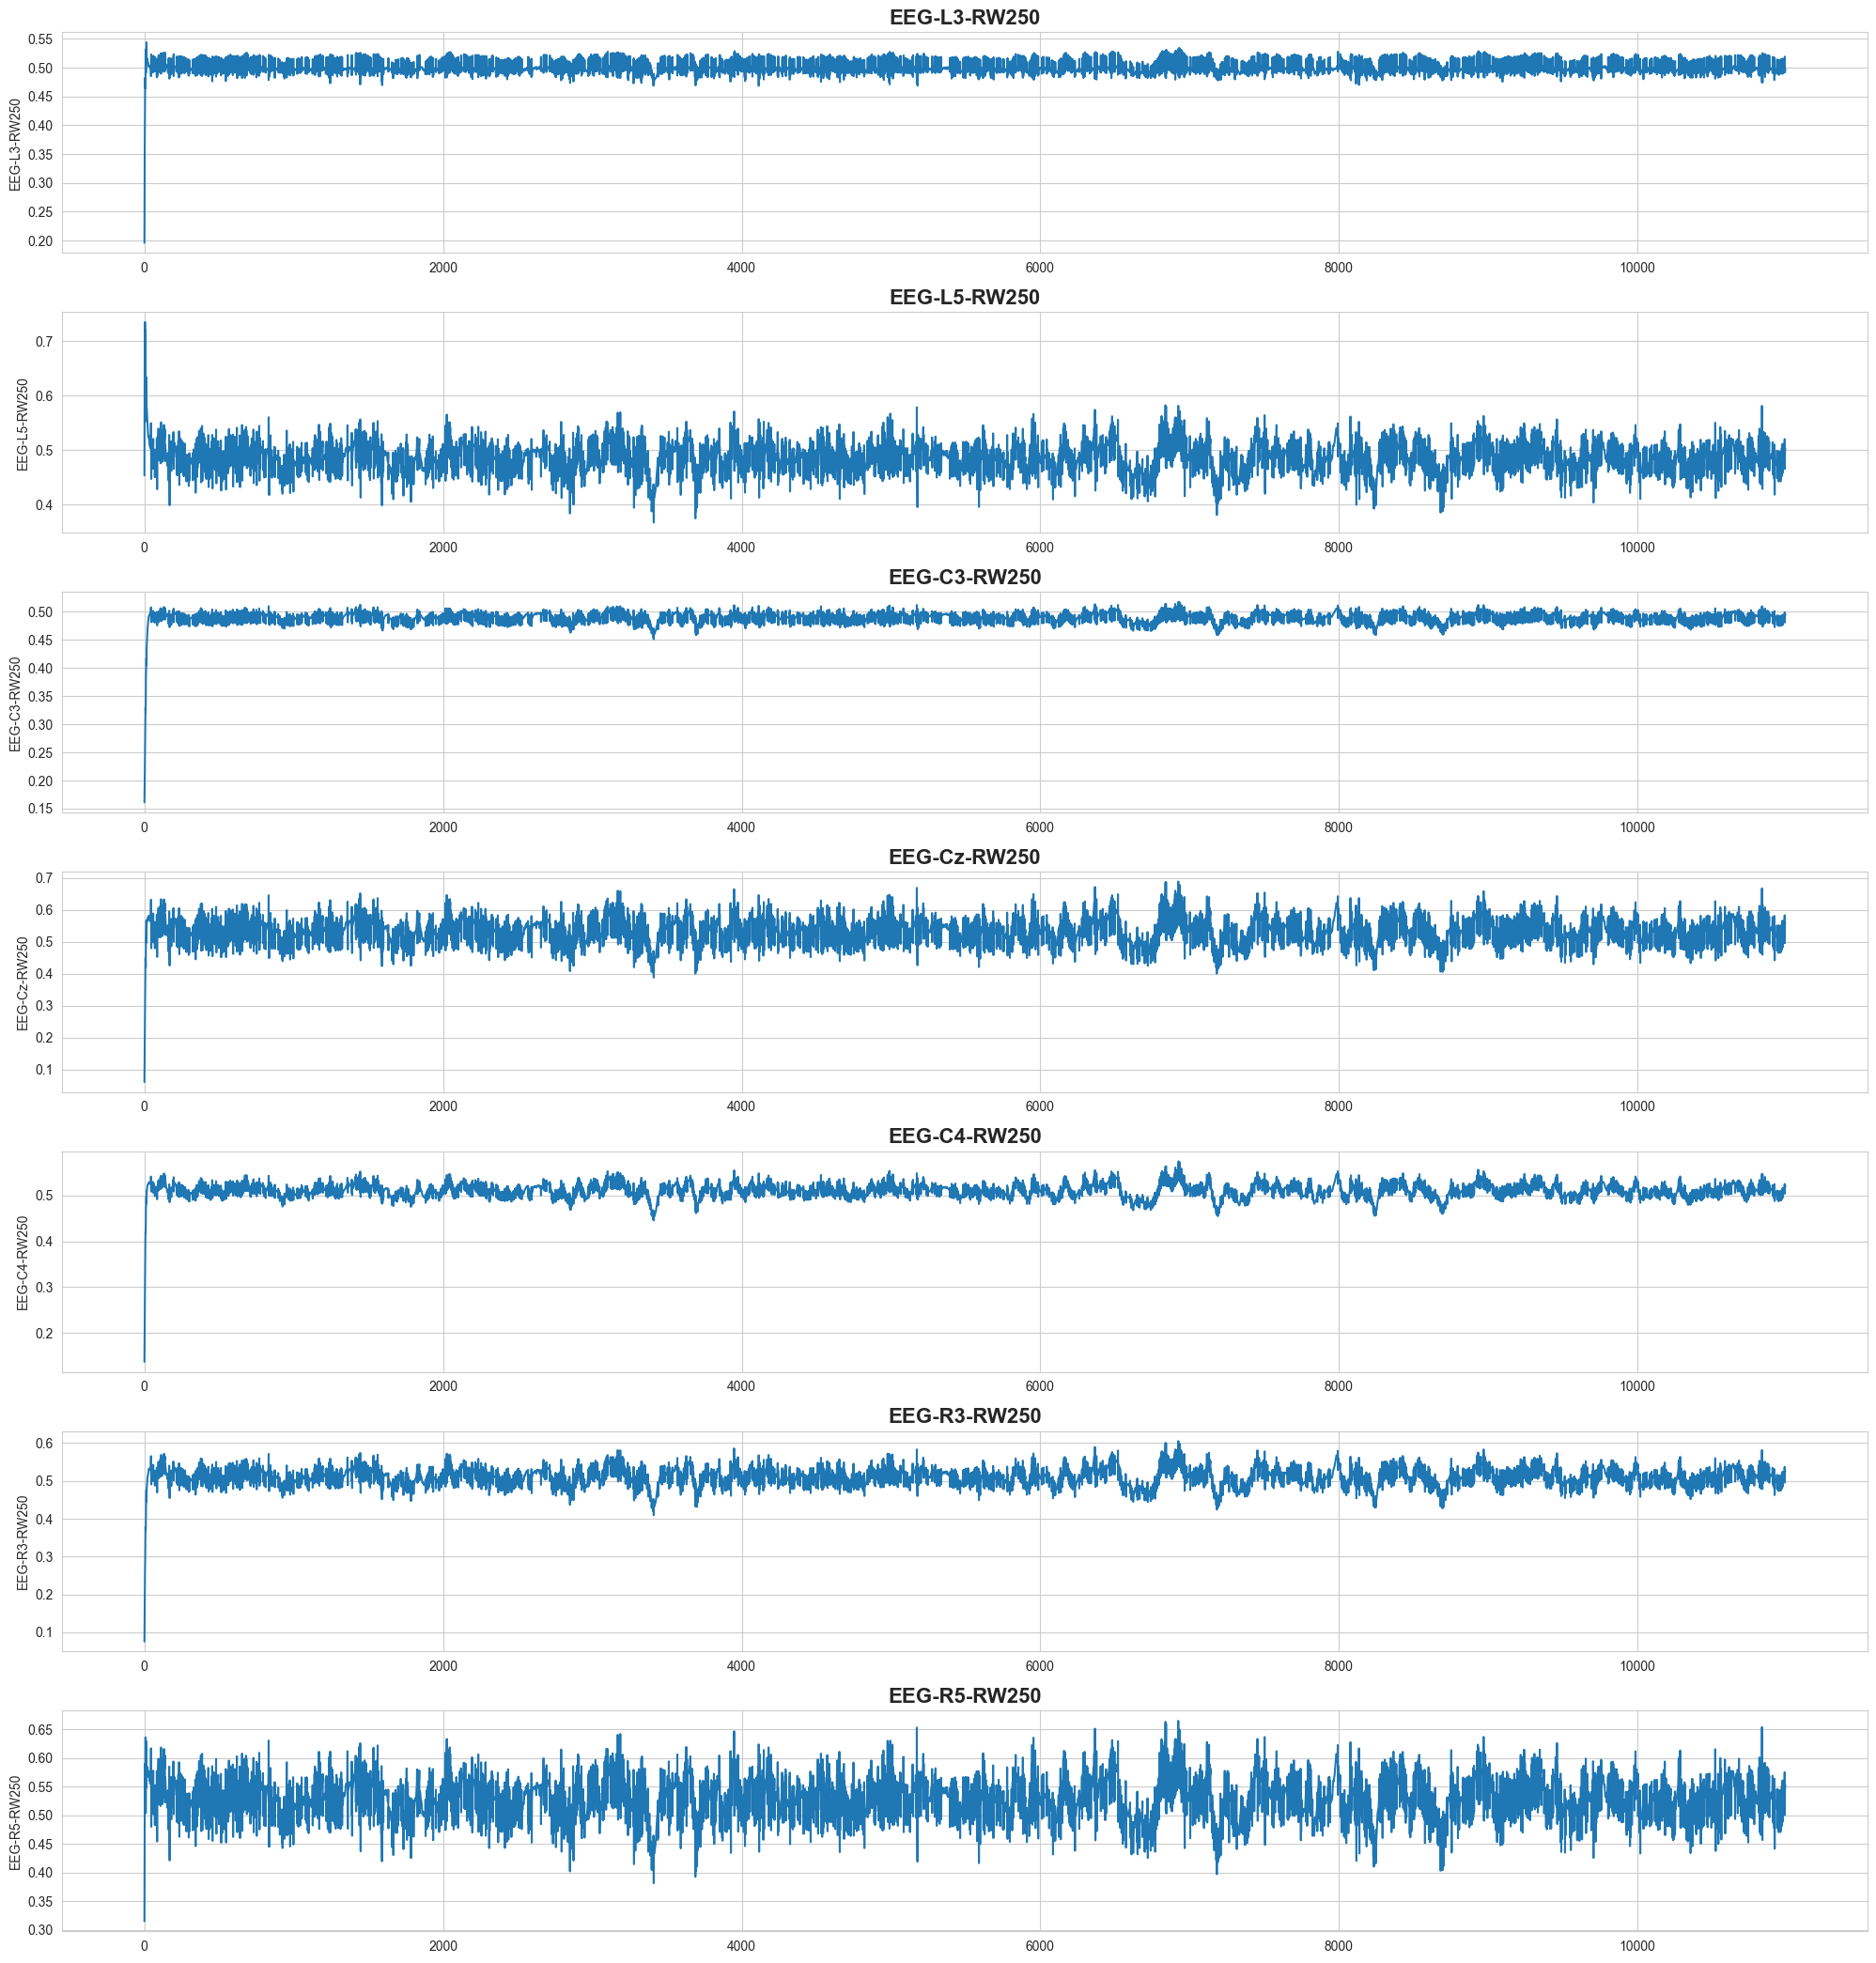

In [21]:
def plot_all_time_series(df: pd.DataFrame) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.endswith(f"RW{250}")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*3))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(test_df)